In [1]:
#Original code contributions by Dipanjan Sarkar
#Follow the link https://www.kdnuggets.com/2018/04/implementing-deep-learning-methods-feature-engineering-text-data-cbow.html

#CBOW model architecture tries to predict current target word ( center word) based on source context words (surrounding words).

#Own contribution - (i) predict the target word based on context word and interpretation of prediction
#                    (ii) loss vs epoch plots

#CONTINUOUS BAG OF WORDS MODEL STEPS

#Build the corpus vocabulary
#Build a CBOW (context, target) generator
#Build the CBOW model architecture
#Train the Model
#Test the Model
#Get Word Embeddings

In [2]:
#Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.preprocessing import text
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Lambda
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
%pprint off

Pretty printing has been turned OFF


In [3]:
#Laurence Sterne, “The Life and Opinions of Tristram Shandy.” 107 words.
corpus = ["The French are certainly misunderstood:- but whether the fault is theirs, in not sufficiently explaining themselves, or speaking with that exact limitation and precision which one would expect on a point of such importance, and which, moreover, is so likely to be contested by us — or whether the fault may not be altogether on our side, in not understanding their language always so critically as to know “what they would be at” — I shall not decide; but ‘tis evident to me, when they affirm, “That they who have seen Paris, have seen every thing,” they must mean to speak of those who have seen it by day-light."]

tokenizer = text.Tokenizer() #Tokenizer instance

#Fit the tokenizer object on the corpus
tokenizer.fit_on_texts(corpus)

#create a dictionary
word2id = tokenizer.word_index

#Build corpus vocabulary

#The PAD term is to pad context words to a fixed length if needed.
word2id['PAD'] = 0

#Exchange key and values and store in id2word for reverse mapping
id2word = {v:k for k, v in word2id.items()}

#Each word is mapped to a number and stored as a list of list
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in corpus]
#print(wids)

#Size of the vocabulary
vocab_size = len(word2id)

#Embedding size
embed_size = 100

#context window size
window_size = 2 

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 80
Vocabulary Sample: [('not', 1), ('to', 2), ('they', 3), ('the', 4), ('be', 5), ('have', 6), ('seen', 7), ('but', 8), ('whether', 9), ('fault', 10)]


In [4]:
#word2id dictionary. Note 'PAD' is initialised to zero
print(word2id)

{'not': 1, 'to': 2, 'they': 3, 'the': 4, 'be': 5, 'have': 6, 'seen': 7, 'but': 8, 'whether': 9, 'fault': 10, 'is': 11, 'in': 12, 'or': 13, 'and': 14, 'which': 15, 'would': 16, 'on': 17, 'of': 18, 'so': 19, 'by': 20, '—': 21, 'who': 22, 'french': 23, 'are': 24, 'certainly': 25, 'misunderstood': 26, 'theirs': 27, 'sufficiently': 28, 'explaining': 29, 'themselves': 30, 'speaking': 31, 'with': 32, 'that': 33, 'exact': 34, 'limitation': 35, 'precision': 36, 'one': 37, 'expect': 38, 'a': 39, 'point': 40, 'such': 41, 'importance': 42, 'moreover': 43, 'likely': 44, 'contested': 45, 'us': 46, 'may': 47, 'altogether': 48, 'our': 49, 'side': 50, 'understanding': 51, 'their': 52, 'language': 53, 'always': 54, 'critically': 55, 'as': 56, 'know': 57, '“what': 58, 'at”': 59, 'i': 60, 'shall': 61, 'decide': 62, '‘tis': 63, 'evident': 64, 'me': 65, 'when': 66, 'affirm': 67, '“that': 68, 'paris': 69, 'every': 70, 'thing': 71, '”': 72, 'must': 73, 'mean': 74, 'speak': 75, 'those': 76, 'it': 77, 'day': 78

In [5]:
#reverse dictionary id2word. Total words including PAD is 80
print(id2word)

{1: 'not', 2: 'to', 3: 'they', 4: 'the', 5: 'be', 6: 'have', 7: 'seen', 8: 'but', 9: 'whether', 10: 'fault', 11: 'is', 12: 'in', 13: 'or', 14: 'and', 15: 'which', 16: 'would', 17: 'on', 18: 'of', 19: 'so', 20: 'by', 21: '—', 22: 'who', 23: 'french', 24: 'are', 25: 'certainly', 26: 'misunderstood', 27: 'theirs', 28: 'sufficiently', 29: 'explaining', 30: 'themselves', 31: 'speaking', 32: 'with', 33: 'that', 34: 'exact', 35: 'limitation', 36: 'precision', 37: 'one', 38: 'expect', 39: 'a', 40: 'point', 41: 'such', 42: 'importance', 43: 'moreover', 44: 'likely', 45: 'contested', 46: 'us', 47: 'may', 48: 'altogether', 49: 'our', 50: 'side', 51: 'understanding', 52: 'their', 53: 'language', 54: 'always', 55: 'critically', 56: 'as', 57: 'know', 58: '“what', 59: 'at”', 60: 'i', 61: 'shall', 62: 'decide', 63: '‘tis', 64: 'evident', 65: 'me', 66: 'when', 67: 'affirm', 68: '“that', 69: 'paris', 70: 'every', 71: 'thing', 72: '”', 73: 'must', 74: 'mean', 75: 'speak', 76: 'those', 77: 'it', 78: 'day'

In [6]:
#Build a CBOW (context, target) generator

#Function that accepts the corpus in terms of sequence, size of window and vocabulary size as inputs
#and yields target word with the surrounding context words

def generate_context_word_pairs(corpus, window_size, vocab_size):
    
    #Context length is twice the window size specified by the user
    context_length = window_size*2
    
    #For every word in corpus
    for words in corpus:
        sentence_length = len(words) #Obtain the length of words
        
        #For every word obtain the context_words and its label
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            #Pad sequence if required and yield sequence and labels
            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = tensorflow.keras.utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [7]:
# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['the', 'french', 'certainly', 'misunderstood'] -> Target (Y): are
Context (X): ['french', 'are', 'misunderstood', 'but'] -> Target (Y): certainly
Context (X): ['are', 'certainly', 'but', 'whether'] -> Target (Y): misunderstood
Context (X): ['certainly', 'misunderstood', 'whether', 'the'] -> Target (Y): but
Context (X): ['misunderstood', 'but', 'the', 'fault'] -> Target (Y): whether
Context (X): ['but', 'whether', 'fault', 'is'] -> Target (Y): the
Context (X): ['whether', 'the', 'is', 'theirs'] -> Target (Y): fault
Context (X): ['the', 'fault', 'theirs', 'in'] -> Target (Y): is
Context (X): ['fault', 'is', 'in', 'not'] -> Target (Y): theirs
Context (X): ['is', 'theirs', 'not', 'sufficiently'] -> Target (Y): in
Context (X): ['theirs', 'in', 'sufficiently', 'explaining'] -> Target (Y): not


In [6]:
#Results interpretation (first instance)
#The first four words are the context words. 
#In this, the first two are words before the center word and the last two are words after the center word
#Then the resulting target center word is "are"

In [8]:
#Try Sequential Neural Network based prediction (CBOW Model)

# build CBOW architecture
cbow = Sequential()

#Input context words passed to embedding layer (initialised with random weights)
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))

#Average out the word embeddings in lambda layer
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))

#Averaged context embedding is passed to a dense softmax layer which outputs the probabilities of each word in the vocab
cbow.add(Dense(vocab_size, activation='softmax'))

#Compile the model
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# view model summary (8000 parameters (vocab_size = 80) * (embed_size = 100) are to be trained)
#No parameters are to be trained at the lambda layer
#80 vocab * 100 embed_size = 8000 + 80(bias) = 8080 parmaters are the output 

print(cbow.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 100)            8000      
_________________________________________________________________
lambda (Lambda)              (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 80)                8080      
Total params: 16,080
Trainable params: 16,080
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
#Train the Model for 100 epochs as vocabulary is just 80. Takes couple of minutes
#train_on_batch - runs a single gradient update on a single batch of data.
Loss = []
Epoch = []
for epoch in range(1, 100):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
    Loss.append(loss)
    Epoch.append(epoch)

In [10]:
# Test this out for some samples. 
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argmax(cbow.predict([x,y]))])
        #print('Context (X):', [id2word[w] for w in x[0]])
        if i == 10:
            break
        i += 1

#Training for 100 epochs for a smaller corpus has yielded good prediction results. 
#Training for less than 10 epochs will result in poor predictions

Context (X): ['the', 'french', 'certainly', 'misunderstood'] -> Target (Y): are
Context (X): ['french', 'are', 'misunderstood', 'but'] -> Target (Y): certainly
Context (X): ['are', 'certainly', 'but', 'whether'] -> Target (Y): misunderstood
Context (X): ['certainly', 'misunderstood', 'whether', 'the'] -> Target (Y): but
Context (X): ['misunderstood', 'but', 'the', 'fault'] -> Target (Y): whether
Context (X): ['but', 'whether', 'fault', 'is'] -> Target (Y): the
Context (X): ['whether', 'the', 'is', 'theirs'] -> Target (Y): fault
Context (X): ['the', 'fault', 'theirs', 'in'] -> Target (Y): is
Context (X): ['fault', 'is', 'in', 'not'] -> Target (Y): theirs
Context (X): ['is', 'theirs', 'not', 'sufficiently'] -> Target (Y): in
Context (X): ['theirs', 'in', 'sufficiently', 'explaining'] -> Target (Y): not


In [11]:
#Get word embeddings for the vocabulary

weights = cbow.get_weights()[0] #Word embedding of PAD
weights = weights[1:] #Exclude word embedding of PAD
print(weights.shape) # 79 (80-1) vocabulary 

#Convert the weights to a dataframe for each of the word
#A single row shows the word embedding done in 100 dimensions by CBOW model 

weightsDF = pd.DataFrame(weights, index=list(id2word.values())[1:]) #Shape (79,100)
weightsDF.head()

(79, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
to,0.852154,-0.909942,0.412170,0.525520,1.155522,-0.697109,0.162528,-0.057547,0.234085,-0.342718,...,-0.501566,-0.265228,-0.989959,-0.558939,0.567455,-0.287729,-1.063588,-0.642793,-0.238514,0.377450
they,-0.355087,0.689162,-0.074675,0.447100,-0.364085,0.082830,-0.587688,0.312270,-0.614695,0.783426,...,0.183202,0.134065,0.158441,-0.761043,0.124788,0.669325,0.381242,0.357798,0.738200,-0.562784
the,0.140297,0.734499,0.016000,0.739054,-0.701238,-0.653234,0.110845,0.206770,-0.818757,0.072044,...,0.013164,-1.080587,0.359994,-0.587371,-0.101311,-0.296440,0.400391,0.139627,0.491590,-0.181183
be,0.563303,-0.332927,-1.126917,0.006636,0.421359,-0.786144,-0.266430,-0.342233,-0.132217,0.121101,...,0.305070,0.348162,-0.080301,0.006818,-0.346357,-0.865583,-0.157885,-0.361634,0.112093,0.262043
have,0.381923,-0.511404,0.446980,-0.875571,0.036914,0.060669,0.046296,-0.639367,-0.149370,-0.550834,...,-0.465896,0.964836,0.733412,-0.442579,0.680833,0.328109,-0.277793,-0.107638,-0.966456,-0.339343


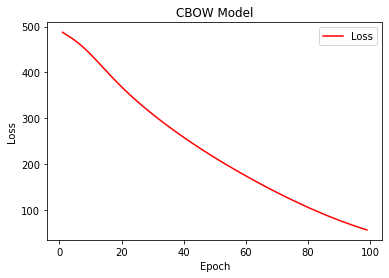

In [12]:
#Plot loss vs epoch
epLoL = list(zip(Epoch, Loss)) #Zip the list
epLoDF = pd.DataFrame(epLoL, columns = ['Epoch','Loss']) #Convert to a dataframe

epLoDF.plot.line(x='Epoch', y= 'Loss', c='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CBOW Model')
plt.show()

#Initially losses are high. Loss is decreasing steadily for 100 epochs. Prediction accuracy will hence improve if trained more.

In [13]:
#Try the CBOW model with slightly larger corpus
#Download Alice in Wonderland from Project Gutenberg and store it in current working directory as Alice.txt

In [15]:
#Open the file
f = open('Alice.txt','r', encoding = 'utf-8')

#Read line by line
alice = f.readlines()

#Remove all \n elements 
alRem = list(map(lambda s: s.strip(), alice ))

#Check total number of elements
print("Total number of list elements: ", len(alRem)) #3773 elements

#List comprehension to remove empty strings
alNoEmpStr = [i for i in alRem if i]

#After removing empty strings, length of the list
print("Total length of list after removing empty strings: ", len(alNoEmpStr)) #2815 elements

#First sentence in Chapter One is 34th element and the last sentence is 2508th element
#prepare a corpus based on these element numbers
alCorpus = alNoEmpStr[34:2508]

print("First two elements: ", alCorpus[0:2]) #First two elements in the list
print("Last two elements: ", alCorpus[-2:]) #Last two elements in the list

Total number of list elements:  3773
Total length of list after removing empty strings:  2815
First two elements:  ['Alice was beginning to get very tired of sitting by her sister on the', 'bank, and of having nothing to do: once or twice she had peeped into']
Last two elements:  ['their simple joys, remembering her own child-life, and the happy summer', 'days.']


In [16]:
#Now corpus is ready for CBOW Modeling
tokenizer = text.Tokenizer() #Tokenizer instance

#Fit the tokenizer object on the Alice corpus
tokenizer.fit_on_texts(alCorpus)

#create a dictionary
word2idAl = tokenizer.word_index

#Build corpus vocabulary

#The PAD term is to pad context words to a fixed length if needed.
word2idAl['PAD'] = 0

#Exchange key and values and store in id2word for reverse mapping
id2wordAl = {v:k for k, v in word2idAl.items()}

#Each word is mapped to a number and stored as a list of list
widsAl = [[word2idAl[w] for w in text.text_to_word_sequence(doc)] for doc in alCorpus]
#print(wids)

#Size of the vocabulary
vocab_size_alice = len(word2idAl)

#Embedding size
embed_size = 100

#context window size
window_size = 2 

print('Vocabulary Size:', vocab_size_alice) #3054
print('Vocabulary Sample:', list(word2idAl.items())[:10])

#Check print(word2idAl) and print(id2wordAl)

Vocabulary Size: 3054
Vocabulary Sample: [('the', 1), ('”', 2), ('and', 3), ('to', 4), ('a', 5), ('she', 6), ('of', 7), ('it', 8), ('said', 9), ('alice', 10)]


In [17]:
#Call the generate_context_word_pairs function created earlier

# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=widsAl, window_size=window_size, vocab_size=vocab_size_alice):
    if 0 not in x[0]:
        print('Context (X):', [id2wordAl[w] for w in x[0]], '-> Target (Y):', id2wordAl[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['alice', 'was', 'to', 'get'] -> Target (Y): beginning
Context (X): ['was', 'beginning', 'get', 'very'] -> Target (Y): to
Context (X): ['beginning', 'to', 'very', 'tired'] -> Target (Y): get
Context (X): ['to', 'get', 'tired', 'of'] -> Target (Y): very
Context (X): ['get', 'very', 'of', 'sitting'] -> Target (Y): tired
Context (X): ['very', 'tired', 'sitting', 'by'] -> Target (Y): of
Context (X): ['tired', 'of', 'by', 'her'] -> Target (Y): sitting
Context (X): ['of', 'sitting', 'her', 'sister'] -> Target (Y): by
Context (X): ['sitting', 'by', 'sister', 'on'] -> Target (Y): her
Context (X): ['by', 'her', 'on', 'the'] -> Target (Y): sister
Context (X): ['bank', 'and', 'having', 'nothing'] -> Target (Y): of


In [18]:
# Sequential Neural Network based CBOW Model for Alice in Wonderland Corpus
cbowAl = Sequential()

#Input context words passed to embedding layer (initialised with random weights)
cbowAl.add(Embedding(input_dim=vocab_size_alice, output_dim=embed_size, input_length=window_size*2))

#Average out the word embeddings in lambda layer
cbowAl.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))

#Averaged context embedding is passed to a dense softmax layer which outputs the probabilities of each word in the vocabulary
cbowAl.add(Dense(vocab_size_alice, activation='softmax'))

#Compile the model
cbowAl.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [19]:
print(cbowAl.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 100)            305400    
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3054)              308454    
Total params: 613,854
Trainable params: 613,854
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
#Number of parameters in the embedding layer = 3054 (Vocabulary of alice corpus) * 100 dimensions = 305400
#Number of parameters in the dense output layer = 3054 * 100 (dim) + 3054 (bias) = 308454 parameters
#All 613854 parameters are trainable compared to 16080 parameters in earlier model of vocab 80 words

In [21]:
#Train the model for 10 epochs. Each epoch takes at least 5 minutes. Total training time approximately 50 minutes
#Loss is high (253695.793 after training for 10 epochs)
LossAl = []
EpochAl = []
for epoch in range(1, 11):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=widsAl, window_size=window_size, vocab_size=vocab_size_alice):
        i += 1
        loss += cbowAl.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))
    LossAl.append(loss)
    EpochAl.append(epoch)

    print('Epoch:', epoch, '\tLoss:', loss)

Epoch: 1 	Loss: 189024.347377792
Epoch: 2 	Loss: 228642.69925283268
Epoch: 3 	Loss: 232614.55808786396
Epoch: 4 	Loss: 236204.89445301797
Epoch: 5 	Loss: 243751.99776859814
Epoch: 6 	Loss: 247549.71646228596
Epoch: 7 	Loss: 249112.8310090748
Epoch: 8 	Loss: 249621.72604524484
Epoch: 9 	Loss: 251936.6662010532
Epoch: 10 	Loss: 253695.79349075432


In [22]:
# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=widsAl, window_size=window_size, vocab_size=vocab_size_alice):
    if 0 not in x[0]:
        print('Context (X):', [id2wordAl[w] for w in x[0]], '-> Target (Y):', id2wordAl[np.argmax(cbowAl.predict([x,y]))])
        
        if i == 10:
            break
        i += 1

#Loss is high even after 10 epochs of training. Hence, the predicted word does not fit in properly

#For second instance 'was begininning get very', the target center word 'to' is predicted correctly
#For sixth instance 'very tired sitting by', the target center word 'of' is predicted correctly
#For ninth instance 'sitting by sister on', the target center word 'her' is predicted correctly

#Computation time for training the model is high for each epoch. 

Context (X): ['alice', 'was', 'to', 'get'] -> Target (Y): mock
Context (X): ['was', 'beginning', 'get', 'very'] -> Target (Y): to
Context (X): ['beginning', 'to', 'very', 'tired'] -> Target (Y): of
Context (X): ['to', 'get', 'tired', 'of'] -> Target (Y): the
Context (X): ['get', 'very', 'of', 'sitting'] -> Target (Y): one
Context (X): ['very', 'tired', 'sitting', 'by'] -> Target (Y): of
Context (X): ['tired', 'of', 'by', 'her'] -> Target (Y): one
Context (X): ['of', 'sitting', 'her', 'sister'] -> Target (Y): and
Context (X): ['sitting', 'by', 'sister', 'on'] -> Target (Y): her
Context (X): ['by', 'her', 'on', 'the'] -> Target (Y): verses
Context (X): ['bank', 'and', 'having', 'nothing'] -> Target (Y): of


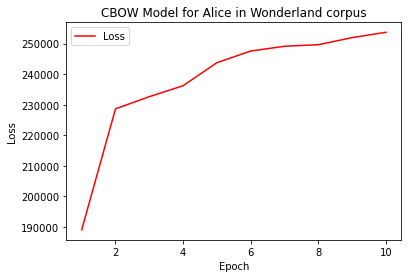

In [23]:
#Plot loss vs epoch for Alice Corpus
epLoAlL = list(zip(EpochAl, LossAl)) #Zip the list
epLoAlDF = pd.DataFrame(epLoAlL, columns = ['Epoch','Loss']) #Convert to a dataframe

epLoAlDF.plot.line(x='Epoch', y= 'Loss', c='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CBOW Model for Alice in Wonderland corpus')
plt.show()

#Loss is increasing after 10 epochs. More training of the neural network is expected to reduce loss

In [24]:
#Get word embeddings for the vocabulary

weightsAl = cbowAl.get_weights()[0] #Word embedding of PAD
weightsAl = weightsAl[1:] #Exclude word embedding of PAD
print(weightsAl.shape) # 3053 (3054-1) vocabulary 

#Convert the weights to a dataframe for each of the word
#A single row shows the word embedding done in 100 dimensions by CBOW model for the alice corpus

#Shape of dataframe (3053,100)

aliceDF = pd.DataFrame(weightsAl, index=list(id2wordAl.values())[1:])
aliceDF.head()

(3053, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
”,-1.444450,-1.679047,1.369818,-1.749136,1.169654,-1.117093,1.990417,-1.209428,1.109718,-1.529737,...,1.694347,-1.397790,1.652419,-1.576714,-1.394550,0.884104,-1.962738,-1.950501,1.593528,-1.789765
and,-0.600773,-1.225610,1.170362,-0.733586,1.096177,-0.975140,2.770817,-1.270958,1.613718,-1.569972,...,0.969279,-1.599138,1.300984,-1.304014,-1.188717,1.050110,-1.654640,-1.252746,1.277909,-1.337074
to,-1.262331,-1.091118,1.393312,-0.968898,1.061633,-1.181811,2.019231,-1.810396,1.375010,-1.461204,...,1.400046,-1.332532,1.497840,-1.117057,-1.116535,1.393804,-1.268740,-1.310565,1.553882,-1.801036
a,-1.112520,-1.400369,1.073033,-1.245233,1.410770,-1.572835,2.268619,-1.201320,1.464215,-1.592534,...,1.100950,-1.672802,1.236765,-0.772997,-1.048615,1.386138,-1.290731,-1.347803,0.959468,-1.423941
she,-1.500956,-0.977607,0.744967,-1.182474,1.851719,-1.195286,2.921041,-1.174504,1.790422,-1.359003,...,1.301445,-1.079242,1.789387,-1.796575,-1.324456,1.499292,-1.353230,-1.283687,1.151912,-2.049520
